In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

sentyment - analiza składni, analiza słow kluczowych, określenie emocjonalnego tonu tekstu

1. Preprocessing
- token
- lower letters
- stemming or lemmantization or both
2. feature extracting
- tf-idf
- word2vec
3. Model
- RNN
- LSTM

##### 1. Understand dataset

In [2]:
df_suicide_detection = pd.read_csv('../data/raw/Suicide_Detection.csv', usecols=['text','class'])
df_suicide_detection.head()

,text,class
0,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,Am I weird I don't get affected by compliments...,non-suicide
2,Finally 2020 is almost over... So I can never ...,non-suicide
3,i need helpjust help me im crying so hard,suicide
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


All of texts are from one forum

In [3]:
df_suicide_detection['class'].value_counts()

class
suicide        116037
non-suicide    116037
Name: count, dtype: int64

Dataset is balanced, there are two class.

In [4]:
df_suicide_detection['class'] = df_suicide_detection['class'].map({'suicide': 1, 'non-suicide':0})

##### 2. Preprocessing

Lowering of letters

In [5]:
df_suicide_detection['text'].iloc[1]

"Am I weird I don't get affected by compliments if it's coming from someone I know irl but I feel really good when internet strangers do it"

In [14]:
df_suicide_detection['corpus'] = df_suicide_detection['text'].apply(lambda x: x.lower())
df_suicide_detection['corpus'].iloc[1]

"am i weird i don't get affected by compliments if it's coming from someone i know irl but i feel really good when internet strangers do it"

Punctuation removal

In [15]:
df_suicide_detection['corpus'].iloc[1]

"am i weird i don't get affected by compliments if it's coming from someone i know irl but i feel really good when internet strangers do it"

In [18]:
df_suicide_detection['corpus'] = df_suicide_detection['corpus'].apply(
    lambda x: x.translate(str.maketrans('', '', string.punctuation))
    .replace('\u200d', '')
    .replace("\n", '')
    .replace("\t", '')
    .replace("’", '')
    )
df_suicide_detection['corpus'].iloc[4]

'im so losthello my name is adam 16 and ive been struggling for years and im afraid through these past years thoughts of suicide fear anxiety im so close to my limit  ive been quiet for so long and im too scared to come out to my family about these feelings about 3 years ago  losing my aunt triggered it all everyday feeling hopeless  lost guilty and remorseful over her and all the things ive done in my lifebut thoughts like these with the little ive experienced in life only time ive revealed these feelings to my family is when i broke down where they saw my cuts watching them get so worried over something i portrayed as an average day made me feel absolutely dreadful they later found out i was an attempt survivor from attempt odoverdose from pills and attempt hanging all that happened was a blackout from the pills and i never went through with the noose because im still so afraid during my first therapy i was diagnosed with severe depression social anxiety and a eating disorderi was la

Remove mails

In [20]:
df_suicide_detection['corpus'].iloc[232069]

'if you dont like rock then your not going to get anything on this but here i go httpsmusictastespacematchlavishwalrus913visionaryeggs973r1'

In [21]:
import re

def remove_links(text):
    link_pattern = r'https?://\S+|www\.\S+|http\S+'
    without_links = re.sub(link_pattern, '', text)
    return without_links

df_suicide_detection['corpus'] = df_suicide_detection['corpus'].apply(remove_links)
df_suicide_detection['corpus'].iloc[232069]

'if you dont like rock then your not going to get anything on this but here i go '

Remove numbers

In [22]:
df_suicide_detection['corpus'].iloc[2]

'finally 2020 is almost over so i can never hear 2020 has been a bad year ever again i swear to fucking god its so annoying'

In [24]:
def remove_numbers(text):
    without_numbers = re.sub(r'\d+', '', text)
    return without_numbers

df_suicide_detection['corpus'] = df_suicide_detection['corpus'].apply(remove_numbers)
df_suicide_detection['corpus'].iloc[2]

'finally  is almost over so i can never hear  has been a bad year ever again i swear to fucking god its so annoying'

Transform emoji

In [26]:
df_suicide_detection['corpus'].iloc[232071]

'pee probably tastes like salty tea😏💦‼️ can someone who drank pee before confirm this🙄‼️'

In [28]:
import emoji

def replace_emoji(text):
    text_with_words = emoji.demojize(text).replace(':', ' ')
    return text_with_words

df_suicide_detection['corpus'] = df_suicide_detection['corpus'].apply(replace_emoji)
df_suicide_detection['corpus'].iloc[232071]

'pee probably tastes like salty tea smirking_face  sweat_droplets  double_exclamation_mark  can someone who drank pee before confirm this face_with_rolling_eyes  double_exclamation_mark '

Tokenization

In [29]:
def tokenize(text):
    return word_tokenize(text)

df_suicide_detection['corpus'] = df_suicide_detection['corpus'].apply(tokenize)
df_suicide_detection['corpus'].head(1)

0    [ex, wife, threatening, suiciderecently, i, le...
Name: corpus, dtype: object

Remove stopwords

In [31]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
# stop_words.discard('no')
# stop_words.discard('not')
# stop_words.discard('don')
stop_words.add('dont')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [33]:
df_suicide_detection['corpus'] = df_suicide_detection['corpus'].apply(
    lambda document: [word for word in document if word not in stop_words]
    )
df_suicide_detection['corpus'].head(1)

0    [ex, wife, threatening, suiciderecently, left,...
Name: corpus, dtype: object

Shorten documents

In [35]:
def shorten_text(text):
    shortened_text = text[:200]
    return shortened_text

df_suicide_detection['corpus'] = df_suicide_detection['corpus'].apply(shorten_text)

Stemming

In [36]:
stemmer = PorterStemmer()

In [43]:
df_suicide_detection['text'] = df_suicide_detection['text'].apply(
    lambda document: [stemmer.stem(word) for word in document]
    )    
df_suicide_detection['text'].head(1)

0    [e, x,  , w, f, e,  , t, h, r, e, e, n, n, g, ...
Name: text, dtype: object

In [45]:
df_suicide_detection['length'] = df_suicide_detection['text'].apply(lambda x: len(x.split()))
df_suicide_detection['post_length'] = df_suicide_detection['corpus'].apply(lambda x: len(x))

len_documents = pd.concat(
    [df_suicide_detection['length'].describe(),
    df_suicide_detection['post_length'].describe()],
    axis=1
)
len_documents.columns = ["before_preprocesing", "after_preprocessing"]
len_documents.drop('count')

,before_preprocesing,after_preprocessing
mean,446.282416,54.091482
std,781.489130,56.246801
min,0.000000,1.000000
25%,90.000000,14.000000
50%,203.000000,30.000000
75%,516.000000,74.000000
max,40074.000000,200.000000


In [39]:
df_suicide_detection[df_suicide_detection['length']==9684]['text']

Series([], Name: text, dtype: object)

In [40]:
len(df_suicide_detection[df_suicide_detection['post_length']==0])

40

In [41]:
df_suicide_detection[df_suicide_detection['post_length']==0]

,text,class,corpus,length,post_length
408,"[︎, , ︎, , ︎, , ︎, , ︎, , ︎, , ︎, , ︎, ...",0,[],80,0
10312,"[_, _, _, _, , _, _, _, _, , _, , _, _, _, ...",0,[],98,0
15952,"[ , 2, !, !, !, , h, w, , r, e, , u, ?]",0,[],14,0
20544,"[., ., ., , -, -, -, , ., ., ., , /, , ., ...",1,[],880,0
21188,"[:, /, :, /]",1,[],4,0
24449,"[1, 8, +, , n, l, , 1, 9, , 2, 0, , 2, 1, ...",0,[],3854,0
26469,"[I, , D, I, D, , I, T, , \n, \n, \n, \n, \n...",0,[],15,0
27232,"[8, =, D, , 8, =, =, =, =, =, =, =, =, =, =, ...",0,[],56,0
35823,"[‍, , ‍, , ‍, , ‍, , ‍, , ‍, , ‍, , ‍, ...",0,[],756,0
44673,"[8, =, =, =, =, =, =, =, =, =, =, =, =, =, =, ...",0,[],105,0


In [42]:
df_suicide_detection = df_suicide_detection[df_suicide_detection['post_length']!=0]

##### 3. Vectorization

In [34]:
vectorizer = TfidfVectorizer()
df_suicide_detection['text'] = df_suicide_detection['text'].apply(lambda x: ' '.join(x))
X = vectorizer.fit_transform(df_suicide_detection['text'])
Y = df_suicide_detection['class'].values

##### 4. Frequency analysis

In [46]:
from collections import Counter
import matplotlib.pyplot as plt

In [47]:
data_suicide = df_suicide_detection[df_suicide_detection['class'] == 1]
data_non_suicide = df_suicide_detection[df_suicide_detection['class'] == 0]

In [48]:
words_suicide = [word for post in data_suicide['corpus'] for word in post]
words_non_suicide = [word for post in data_non_suicide['corpus'] for word in post]

In [49]:
word_freq_suicide = Counter(words_suicide)
word_freq_non_suicide = Counter(words_non_suicide)

In [50]:
top_10_words_suicide = word_freq_suicide.most_common(10)
top_10_words_non_suicide = word_freq_non_suicide.most_common(10)

print("Top 10 words in 'suicide':\n", top_10_words_suicide)
print("Top 10 words in 'non-suicide':\n", top_10_words_non_suicide)

Top 10 words in 'suicide':
 [('im', 232487), ('want', 110513), ('like', 109336), ('feel', 92595), ('life', 92536), ('know', 88783), ('ive', 80575), ('cant', 78114), ('get', 70336), ('even', 62689)]
Top 10 words in 'non-suicide':
 [('im', 58230), ('like', 47426), ('filler', 33636), ('get', 23538), ('know', 23065), ('people', 20551), ('want', 19456), ('one', 18333), ('really', 17525), ('time', 15083)]


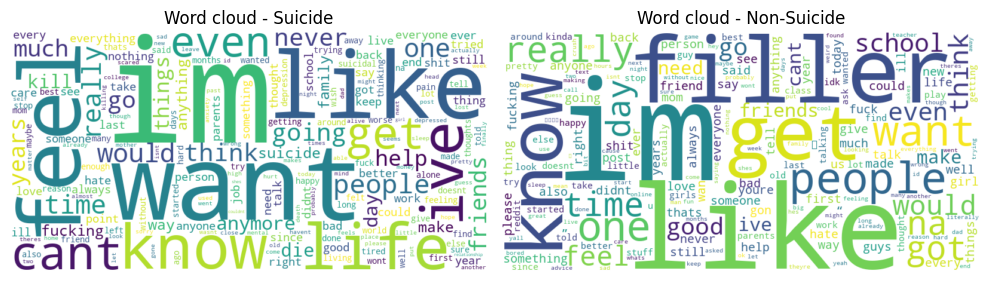

In [51]:
from wordcloud import WordCloud

wordcloud_suicide = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_suicide)
wordcloud_non_suicide = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_non_suicide)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_suicide, interpolation='bilinear')
plt.title('Word cloud - Suicide')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_non_suicide, interpolation='bilinear')
plt.title('Word cloud - Non-Suicide')
plt.axis('off')

plt.tight_layout()
plt.show()

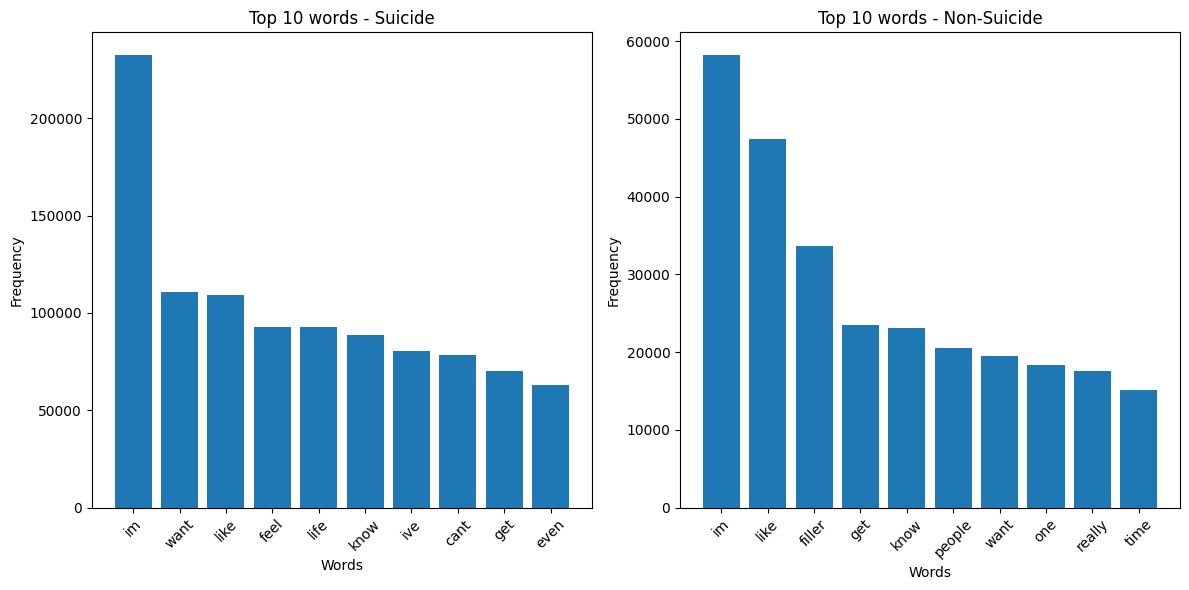

In [52]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(*zip(*top_10_words_suicide))
plt.title('Top 10 words - Suicide')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.bar(*zip(*top_10_words_non_suicide))
plt.title('Top 10 words - Non-Suicide')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

##### 5. Analysis of Length

In [57]:

len_documents = pd.concat(
    [data_suicide['length'].describe(),
    data_non_suicide['length'].describe(),
    data_suicide['post_length'].describe(),
    data_non_suicide['post_length'].describe()],
    axis=1
)
len_documents.columns = ["suicide","non_suicide","suicide_preprocesing", "non_suicide_preprocessing"]
len_documents.drop('count')

,suicide,non_suicide,suicide_preprocesing,non_suicide_preprocessing
mean,674.469555,218.055936,79.871952,28.306568
std,854.653845,621.960916,61.918560,34.114342
min,0.000000,1.000000,1.000000,1.000000
25%,198.000000,65.000000,29.000000,10.000000
50%,419.000000,108.000000,61.000000,17.000000
75%,832.000000,208.000000,118.000000,31.000000
max,25869.000000,40074.000000,200.000000,200.000000


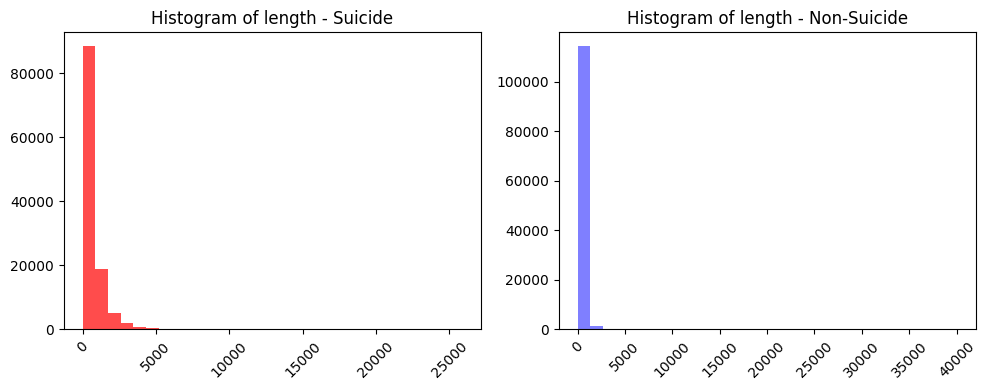

In [60]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(data_suicide['length'],bins=30, alpha=0.7, color='red', label='Suicide')
plt.title('Histogram of length - Suicide')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.hist(data_non_suicide['length'], bins=30, alpha=0.5, color='blue', label='Non-Suicide')
plt.title('Histogram of length - Non-Suicide')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

##### 6. Thematic Analysis

##### 7. Sentiment Analysis

##### 8. Association Analysis

##### 9. Visual and interactive analysis